# ANCOVA

## Weight Lost

Research Question: We want to investigate if the weightlost is different according to the Diet and the Gender.

We need to create the variable weight lost because this is the continuous variable that we want to compare between Diets and Genders:

In [29]:
import pandas as pd

# URL to the CSV file
url = "https://github.com/kflisikowski/ms/blob/main/diet.csv?raw=true"

# Load the data into a DataFrame directly from the URL
diet = pd.read_csv(url)

# Calculate the weight lost and add it as a new column
diet['weightlost'] = diet['weight6weeks'] - diet['pre.weight']

# Display the first few rows of the data
diet

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks,weightlost
0,25,,41,171,60,2,60.0,0.0
1,26,,32,174,103,2,103.0,0.0
2,1,0,22,159,58,1,54.2,-3.8
3,2,0,46,192,60,1,54.0,-6.0
4,3,0,55,170,64,1,63.3,-0.7
...,...,...,...,...,...,...,...,...
73,74,1,35,183,83,3,80.2,-2.8
74,75,1,49,177,84,3,79.9,-4.1
75,76,1,28,164,85,3,79.7,-5.3
76,77,1,40,167,87,3,77.8,-9.2


It would be nice to start without any outliers and NA's. Let's solve this problem

In [30]:
import pandas as pd
import numpy as np
from scipy import stats

# URL to the CSV file
url = "https://github.com/kflisikowski/ms/blob/main/diet.csv?raw=true"

# Load the data into a DataFrame
diet = pd.read_csv(url)

# Calculate the weight lost and add it as a new column
diet['weightlost'] = diet['weight6weeks'] - diet['pre.weight']

# Function to impute outliers with the median
def impute_outliers(group, column):
    z_scores = np.abs(stats.zscore(group[column]))
    median = group[column].median()
    group[column] = np.where(z_scores > 3, median, group[column])
    return group

# Group by 'Diet' and 'gender' and impute outliers in 'weightlost'
diet = diet.groupby(['Diet', 'gender'], group_keys=False).apply(lambda group: impute_outliers(group, 'weightlost'))

# Function to impute missing values with the mode
def impute_na(df, column, group_by_column):
    mode = df.groupby(group_by_column)[column].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    df[column].fillna(mode, inplace=True)
    return df

# Impute missing values in 'gender' based on the mode within each 'Diet' group
diet = impute_na(diet, 'gender', 'Diet')

# Display the first few rows of the data
print(diet.head())

   Person gender  Age  Height  pre.weight  Diet  weight6weeks  weightlost
0      25          41     171          60     2          60.0         0.0
1      26          32     174         103     2         103.0         0.0
2       1      0   22     159          58     1          54.2        -3.8
3       2      0   46     192          60     1          54.0        -6.0
4       3      0   55     170          64     1          63.3        -0.7


We need to rearrange the categorical variables "Diet" and "gender" so that we can read their real values: 0 -\> "Female" and 1 -\> "Male". It is always advised to transform your categorical variables so that we can see their meaning later on when you plot graphs. It is indeed nicer to have a graph indicating that such gender is "Male" rather than just a number 1...

In [31]:
# Replace empty strings with NaN
diet.replace('', np.nan, inplace=True)

# Replace numerical values with categorical labels for gender
diet['gender'] = diet['gender'].replace({'0': 'Female', '1': 'Male'})

# Replace numerical values with categorical labels for Diet
diet['Diet'] = diet['Diet'].replace({1: 'Diet 1', 2: 'Diet 2', 3: 'Diet 3'})

# Display the first few rows of the data
print(diet.head())

   Person  gender  Age  Height  pre.weight    Diet  weight6weeks  weightlost
0      25           41     171          60  Diet 2          60.0         0.0
1      26           32     174         103  Diet 2         103.0         0.0
2       1  Female   22     159          58  Diet 1          54.2        -3.8
3       2  Female   46     192          60  Diet 1          54.0        -6.0
4       3  Female   55     170          64  Diet 1          63.3        -0.7


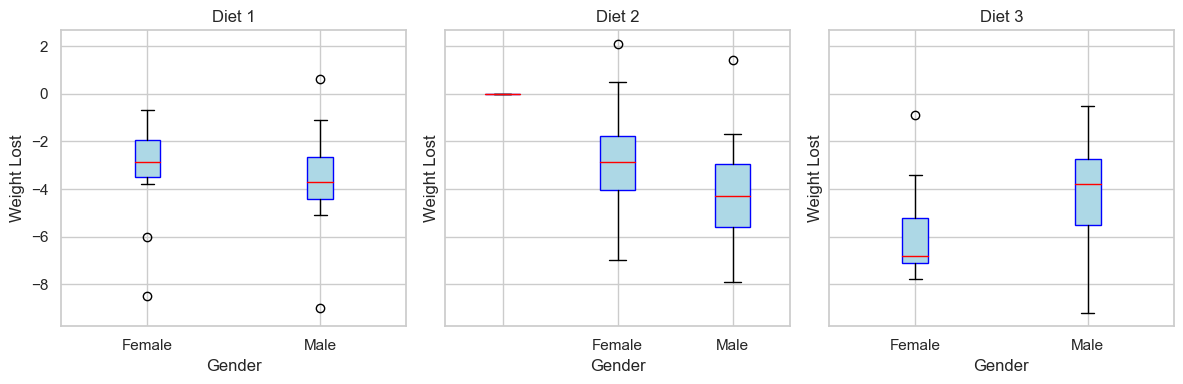

In [33]:
import matplotlib.pyplot as plt

# Assuming `diet` is a pandas DataFrame and has columns `gender`, `weightlost`, and `Diet`
fig, axes = plt.subplots(1, len(diet['Diet'].unique()), figsize=(12, 4), sharey=True)

# Loop through each unique diet category
for ax, (diet_name, group) in zip(axes, diet.groupby('Diet')):
    # Create a boxplot for each diet
    ax.boxplot(
        [group[group['gender'] == g]['weightlost'] for g in group['gender'].unique()],
        labels=group['gender'].unique(),
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='blue'),
        medianprops=dict(color='red')
    )
    ax.set_title(diet_name)
    ax.set_xlabel('Gender')
    ax.set_ylabel('Weight Lost')

plt.tight_layout()
plt.show()


/var/folders/99/w3lm9dwd2q929kjsdm9dyy7c0000gn/T/ipykernel_76937/1269054609.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diet.replace('', np.nan, inplace=True)


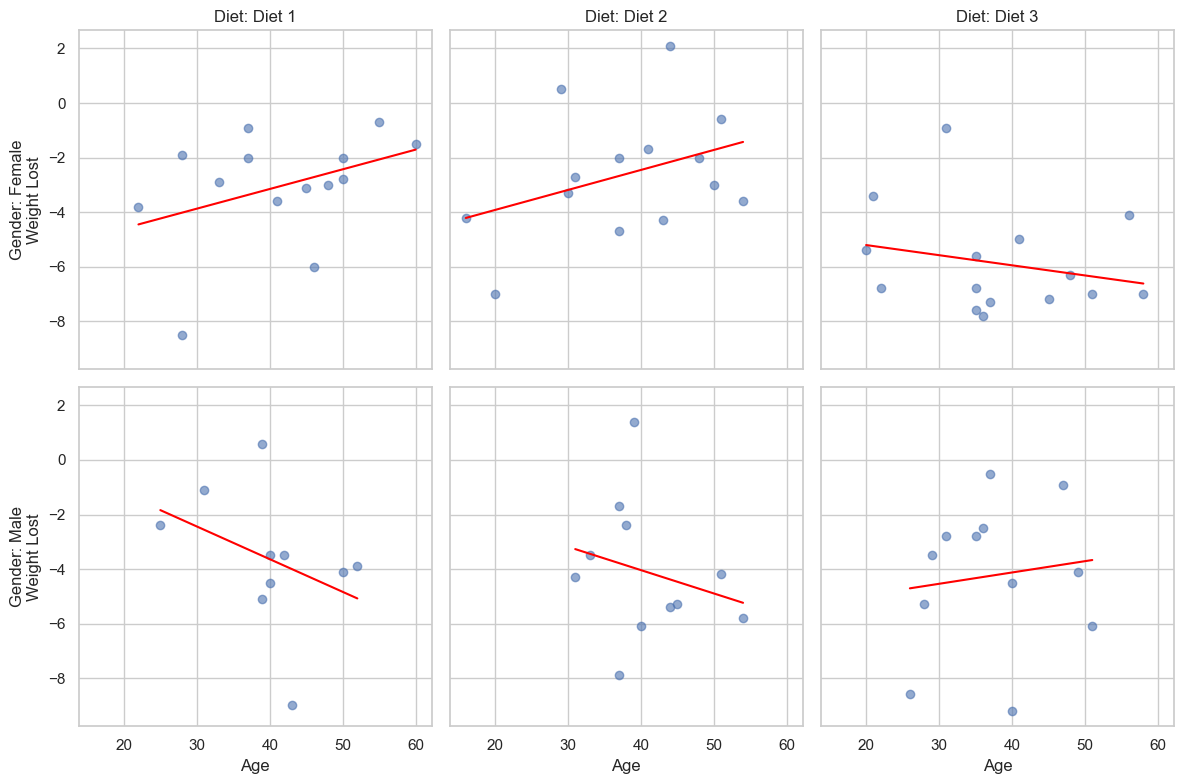

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace empty strings with NaN
diet.replace('', np.nan, inplace=True)

# Exclude third gender level
diet = diet[diet['gender'].isin(['Female', 'Male'])]

# Get unique values for rows and columns
diets = diet['Diet'].unique()
genders = diet['gender'].unique()

# Create a grid of subplots
fig, axes = plt.subplots(len(genders), len(diets), figsize=(12, 8), sharex=True, sharey=True)

# Ensure axes are 2D for consistency
axes = np.atleast_2d(axes)

# Loop through each combination of diet and gender
for i, gender in enumerate(genders):
    for j, diet_name in enumerate(diets):
        ax = axes[i, j]
        subset = diet[(diet['Diet'] == diet_name) & (diet['gender'] == gender)]

        # Scatter plot
        ax.scatter(subset['Age'], subset['weightlost'], alpha=0.6, label="Data")

        # Regression line
        if not subset.empty:
            # Fit a line using numpy's polyfit
            slope, intercept = np.polyfit(subset['Age'], subset['weightlost'], 1)
            x_vals = np.linspace(subset['Age'].min(), subset['Age'].max(), 100)
            y_vals = slope * x_vals + intercept
            ax.plot(x_vals, y_vals, color='red', label="Regression")

        # Titles and labels
        if i == 0:  # Top row, set column titles
            ax.set_title(f"Diet: {diet_name}")
        if j == 0:  # Leftmost column, set row titles
            ax.set_ylabel(f"Gender: {gender}\nWeight Lost")
        if i == len(genders) - 1:  # Bottom row, set x-axis label
            ax.set_xlabel("Age")

# Adjust layout and show plot
fig.tight_layout()
plt.show()

## Assumptions

Assumptions:

1)  No significant outliers for each combination of the groups of the two independent variables.

In [36]:
# Function to identify outliers
def identify_outliers(group):
    z_scores = stats.zscore(group['weightlost'])
    abs_z_scores = abs(z_scores)
    outliers = abs_z_scores > 3
    return group[outliers]

# Group by 'gender' and 'Diet' and identify outliers in 'weightlost'
outliers = diet.groupby(['gender', 'Diet']).apply(identify_outliers).reset_index(drop=True)

# Display the outliers
print(outliers)

Empty DataFrame
Columns: [Person, gender, Age, Height, pre.weight, Diet, weight6weeks, weightlost]
Index: []


2)  Dependent variable of the ANOVA should be approximately normally distributed for each combination of groups.

In [37]:
import pandas as pd
from scipy.stats import shapiro

# Function to perform Shapiro-Wilk test
def shapiro_test(group):
    stat, p_value = shapiro(group['weightlost'].dropna())
    return pd.Series({'W-statistic': stat, 'p-value': p_value})

# Group by 'gender' and 'Diet' and perform Shapiro-Wilk test on 'weightlost'
shapiro_results = diet.groupby(['gender', 'Diet']).apply(shapiro_test).reset_index()

# Display the results
print(shapiro_results)

   gender    Diet  W-statistic   p-value
0  Female  Diet 1     0.851801  0.023499
1  Female  Diet 2     0.978617  0.966003
2  Female  Diet 3     0.849200  0.016919
3    Male  Diet 1     0.936675  0.516644
4    Male  Diet 2     0.950221  0.646774
5    Male  Diet 3     0.941426  0.516765


## Normality plots:

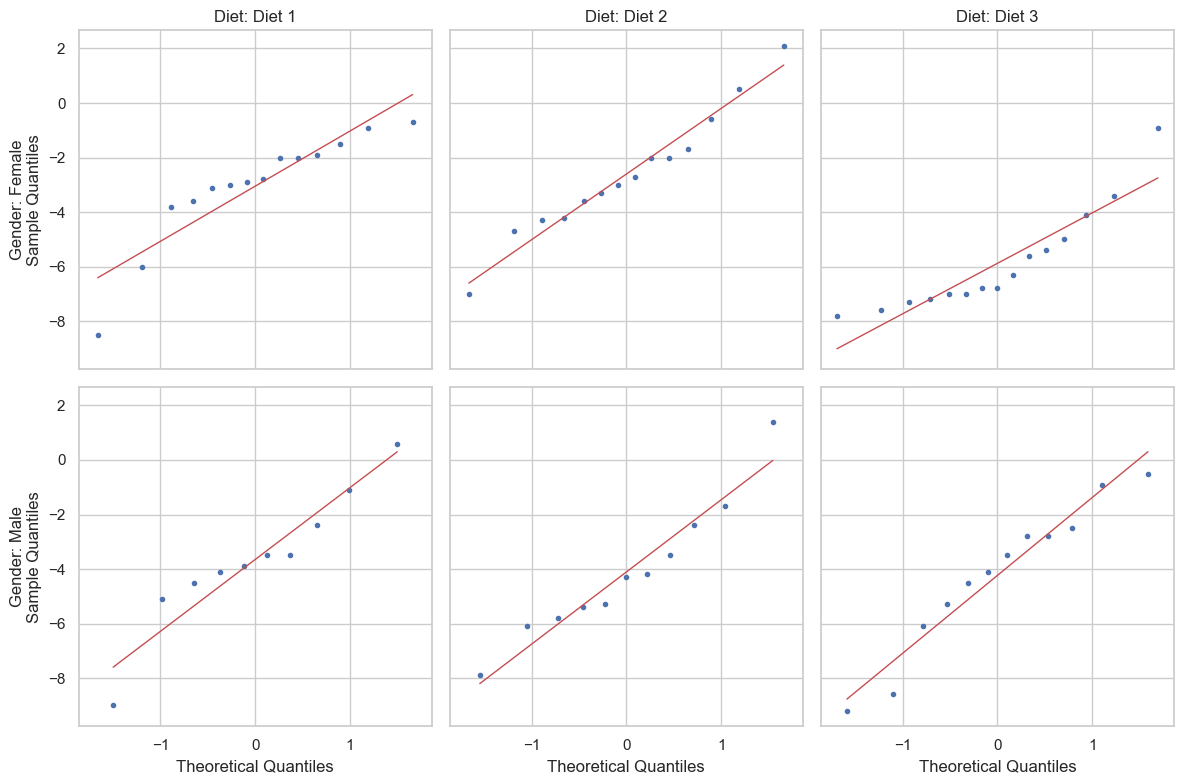

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Get unique values for rows and columns
diets = diet['Diet'].unique()
genders = diet['gender'].unique()

# Create a grid of subplots
fig, axes = plt.subplots(len(genders), len(diets), figsize=(12, 8), sharex=True, sharey=True)

# Ensure axes are 2D for consistency
axes = np.atleast_2d(axes)

# Loop through each combination of diet and gender
for i, gender in enumerate(genders):
    for j, diet_name in enumerate(diets):
        ax = axes[i, j]
        subset = diet[(diet['Diet'] == diet_name) & (diet['gender'] == gender)]['weightlost']

        # Q-Q plot
        if not subset.empty:
            (osm, osr), (slope, intercept, r) = stats.probplot(subset, plot=None)
            ax.plot(osm, osr, 'o', markersize=3, label="Data")
            ax.plot(osm, slope * osm + intercept, 'r', lw=1, label="Fit")

        # Titles and labels
        if i == 0:  # Top row, set column titles
            ax.set_title(f"Diet: {diet_name}")
        if j == 0:  # Leftmost column, set row titles
            ax.set_ylabel(f"Gender: {gender}\nSample Quantiles")
        if i == len(genders) - 1:  # Bottom row, set x-axis label
            ax.set_xlabel("Theoretical Quantiles")

# Adjust layout and show plot
fig.tight_layout()
plt.show()

In this combination (Female in Diet 1&3), the data looks skewed. But since in all the other combinations, there is a symmetrical distribution and the ANOVA is considered as a robust test, you can still go for the 2-way ANOVA.

3)  Homogeneity of Variances for each combination of groups.

In [40]:
from scipy.stats import levene

# Create a combined factor for gender and Diet
diet['gender_Diet'] = diet['gender'] + '_' + diet['Diet']

# Perform Levene's test
groups = [group['weightlost'].dropna().values for name, group in diet.groupby('gender_Diet')]
stat, p_value = levene(*groups)

# Display the results
print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 0.38669356585167536
p-value: 0.8563346613193741


P-value > 0.05, so we keep Homogeneity of Variance (or do not reject it) and we can go on.

## 2-way Anova

In [41]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform two-way ANOVA
model = ols('weightlost ~ gender * Diet', data=diet).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the results
print(anova_table)

                 sum_sq    df         F    PR(>F)
gender         0.168696   1.0  0.031379  0.859910
Diet          60.417220   2.0  5.619026  0.005456
gender:Diet   33.904068   2.0  3.153204  0.048842
Residual     376.329043  70.0       NaN       NaN



-   Strange! There is no significant difference of weight lost between Genders.

-   There is a strong significant difference between the Diets.

-   There is a significant interaction effect.

So in the end, Gender is to be taken into account because there is an interaction effect!

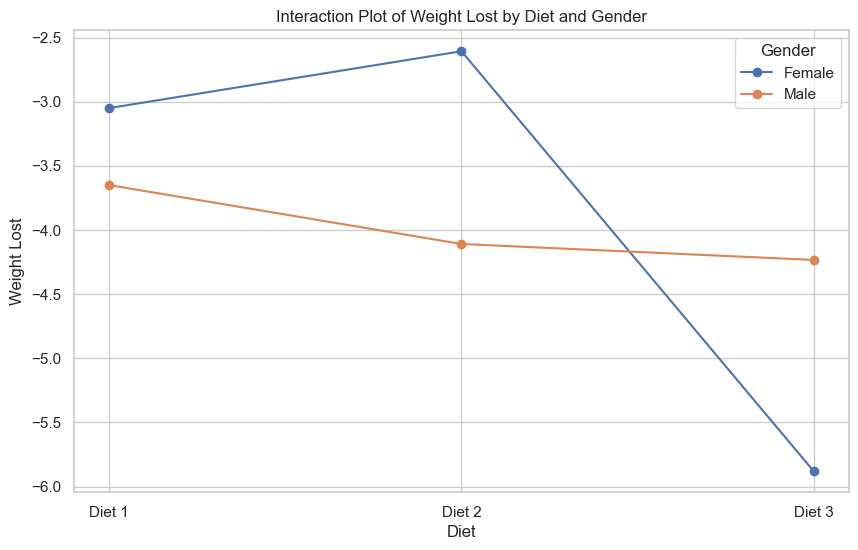

In [43]:
# Get unique genders and diets
genders = diet['gender'].unique()
diets = diet['Diet'].unique()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot lines for each gender
for gender in genders:
    subset = diet[diet['gender'] == gender]
    means = subset.groupby('Diet')['weightlost'].mean()
    plt.plot(means.index, means.values, marker='o', label=gender)

# Set titles and labels
plt.xlabel('Diet')
plt.ylabel('Weight Lost')
plt.title('Interaction Plot of Weight Lost by Diet and Gender')
plt.legend(title='Gender')

# Show the plot
plt.show()

Typical case of interaction: The lines are not parallel = Interaction!

Post-hoc tests:

In [44]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform two-way ANOVA
model = ols('weightlost ~ gender * Diet', data=diet).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results
print(anova_table)

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=diet['weightlost'], groups=diet['gender'] + ' & ' + diet['Diet'], alpha=0.05)

# Display the results of Tukey's HSD test
print(tukey)

                 sum_sq    df         F    PR(>F)
gender         0.168696   1.0  0.031379  0.859910
Diet          60.417220   2.0  5.619026  0.005456
gender:Diet   33.904068   2.0  3.153204  0.048842
Residual     376.329043  70.0       NaN       NaN
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
Female & Diet 1 Female & Diet 2   0.4429 0.9958  -2.125  3.0107  False
Female & Diet 1 Female & Diet 3    -2.83 0.0191 -5.3547 -0.3053   True
Female & Diet 1   Male & Diet 1     -0.6 0.9888  -3.413   2.213  False
Female & Diet 1   Male & Diet 2  -1.0591 0.8657 -3.7965  1.6783  False
Female & Diet 1   Male & Diet 3  -1.1833 0.7855 -3.8561  1.4894  False
Female & Diet 2 Female & Diet 3  -3.2729  0.004 -5.7976 -0.7481   True
Female & Diet 2   Male & Diet 1  -1.0429 0.8852 -3.8558  1.7701  False
Female & Diet 2   Male & Diet 2  -1.5019

## 1-way Ancova DIY

A one-way ANCOVA is similar to a one-way ANOVA. However by comparing a measurement scale between 3 or more groups, we control for another continuous variable, called the covariate.

This covariate is a variable that you think might affect the results we obtained in the one-way ANOVA.

There can be several covariates.

Research question: Is there a significant difference of weight lost between the types of Diet while controlling for the height of the participants?


Assumptions:

1)  No significant outliers for each category (Diet).

2)  Dependent variable of the ANOVA should be approximately normally distributed for each category (Diet).

3)  Homogeneity of Variances: Variances statistically similar between different Diets.

1-way Ancova test:

Conclusions:

In order to conduct ANCOVA post-hoc tests (that is pairwise comparisons while controlling for covariate 'Height'), type the same function TukeyHSD and specify the independent variable 'Diet'. 

Post-hoc tests: 

## 2-way Ancova DIY

Research question: Is there a significant difference of weight lost between the types of Diet and the Gender while controlling for the height of the participants?

Pretty much similar to the 2-way ANCOVA but you will add an extra independent factor “Gender”.

"+" to add the covariate(s) "\*" when it is an independent factor added to Diet.

## Mixed Anova DIY

-   Research question: Is there a significant difference of lost weight between the types of Diet and the Gender while controlling for the height and the age of the participants?

-   The between-subjects factor is Diet.

-   The within-subjects factor is Time ("pre" and "after 6 weeks")

Unfortunately, the format the data is presented is not ready for analysing a Repeated ANOVA!

## Power Analysis

The power of a test statistics is to be taken as a score from 0 to 100%. It measures the reliability of your test.

The power depends on the sample size and the bigger your sample size, the more power you will have, and thus the more reliable your test is.

The power required in statistics is usually 80%.

In the functions provided in this course, you need to specify the p-value threshold (0.05 generally) and a parameter called the effect size.

After that, you can either specify the sample size you have in order to get the power, or conversely, specify the power in order to know what minimum sample size you need.

What to do in case the sample size is not enough?

-   Try to collect more data.

-   Report the effect sizes.

-   Report some descriptive statistics.

-   You can increase the p-value threshold to 0.10. I.e. You will have a significant result if the p-value is less than 0.10.
